# General Notebook on fine-tuning branch point prediction using any of MultiMolecule models

Any RNA model can be selected from the [MultiMolecule](https://multimolecule.danling.org/models/) website. Simple change the `MULTIMOLECULE_MODEL` variable in the cell below, and the the two cells under the tokenizer "Load the desired model and tokenizer" section.

In [1]:
# GLOBAL VARIABLES
WORKING_DIRECTORY = '/content/drive/MyDrive/epfl_ml_project'
DATASET_PATH = 'data/fresh_dataset.txt'
MODEL_MAX_INPUT_SIZE = 1024
MULTIMOLECULE_MODEL = "utrlm-te_el"
SAMPLE_N_DATAPOINTS = 10000 # Sample a small subset of data for testing purposes. Set to None if training on full dataset
SEED = 32

In [2]:
%%capture
!pip install datasets evaluate multimolecule==0.0.5

In [3]:
import pandas as pd
import torch
from transformers import (
#     AutoTokenizer,
#     AutoModel,
#     AutoModelForMaskedLM,
     AutoModelForTokenClassification,
     DataCollatorForTokenClassification,
     TrainingArguments,
     Trainer
)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd {WORKING_DIRECTORY}

from BP_LM.scripts.data_preprocessing import *
from BP_LM.scripts.trainer_datasets_creation import *
from BP_LM.scripts.compute_metrics import *

Mounted at /content/drive
/content/drive/MyDrive/epfl_ml_project


## Load the desired model and tokenizer

In [6]:
# Change this import depending on the model
from multimolecule import RnaTokenizer, UtrLmForTokenPrediction, UtrLmConfig

tokenizer = RnaTokenizer.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')
# Change line below depending on what model we want

config = UtrLmConfig()
config.problem_type = "single_label_classification"
config.num_labels = 2
model = UtrLmForTokenPrediction.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}', config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.93M [00:00<?, ?B/s]

Some weights of UtrLmForTokenPrediction were not initialized from the model checkpoint at multimolecule/utrlm-te_el and are newly initialized: ['token_head.decoder.bias', 'token_head.decoder.weight', 'utrlm.pooler.dense.bias', 'utrlm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up the collator
data_collator = DataCollatorForTokenClassification(tokenizer)

## Create dataset objects for training

In [7]:
# Load dataset
df = pd.read_csv(DATASET_PATH, sep='\t')

train_dataset, val_dataset, test_dataset = create_dataset(df, tokenizer, model, MODEL_MAX_INPUT_SIZE, SEED, SAMPLE_N_DATAPOINTS)

Chromosomes in train set: {'chr14', 'chrY', 'chr1', 'chr22', 'chr3', 'chr7', 'chrX', 'chr15', 'chr13', 'chr4', 'chr12', 'chr5', 'chr17', 'chr2', 'chr16', 'chr6', 'chr19', 'chr20', 'chr18', 'chr21'}
Chromosomes in validation set: {'chr10', 'chr9'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 10000
Train set contains 8287 data points (82.87%)
Validation set contains 807 data points (8.07%)
Test set contains 906 data points (9.06%)


## Train model

In [9]:
# Do not save to W&B
import os
os.environ["WANDB_MODE"] = "disabled"

In [10]:
# Notebook for computing metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (average_precision_score,
                             PrecisionRecallDisplay,
                             precision_recall_curve,
                             matthews_corrcoef,
                             roc_auc_score)
from scipy.special import softmax, expit


def compute_metrics1(eval_pred, filename):
    """
    Function to simultaneously evaluate accuracy, F1 and average precision (AP)

    The function does the evaluation per label for accuracy, and per token otherwise.

    average precision is the most interesting as it accounts for the fact that the
    ideal decision boundary may be something non trivial.

    F1 and accuracy are reported at the decision boundary which maximises the F1
    """
    raw_predictions, labels = eval_pred

    logits = raw_predictions # Discard hidden states and keep logits
    print(f"logits shape: {logits.shape}")
    print(logits[0,:,:])

    # Find predictions from logits
    predictions = 1 - softmax(logits, axis=2)[:,:,0]  # Shape will be (56, 1024, 1)

    # Reshape predictions to remove the last dimension (since it's just 1, it can be dropped)
    # predictions = predictions.reshape(logits.shape[0], logits.shape[1])
    print(predictions[0,:])

    # Reshape predictions and labels into long strings to compute metrics per token
    predictions_flat = predictions.reshape((-1,))
    labels_flat = labels.reshape((-1,))

    # Remove all the padded ones
    predictions_flat = predictions_flat[labels_flat!=-100]
    labels_flat_cleaned = labels_flat[labels_flat!=-100]

    # Compute average precision
    AP = average_precision_score(labels_flat_cleaned, predictions_flat)

    # Plot precision curves
    precision, recall, thresholds = precision_recall_curve(labels_flat_cleaned, predictions_flat)
    fig, ax = plt.subplots(dpi = 300, figsize = (5,3))
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall Curve at final epoch: splicebert", fontsize = 12)
    ax.plot(recall, precision)
    fig.savefig("Precision-Recall Curve at final epoch: splicebert.png")

    np.savetxt(f'pr_curve_{filename}.txt', np.vstack((precision,recall)).T)

    #Compute ideal boundary and optimized F1
    ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
    F1 = np.nanmax(2 * (precision * recall) / (precision + recall))

    #Calculate accuracy
    categorical_predictions = np.where(predictions>ideal_threshold, 1, 0)
    accuracy = compute_accuracy(labels, categorical_predictions)

    categorical_predictions_flat = categorical_predictions.reshape((-1,))
    categorical_predictions_flat = categorical_predictions_flat[labels_flat!=-100]

    MCC = matthews_corrcoef(labels_flat_cleaned, categorical_predictions_flat)
    AUC = roc_auc_score(labels_flat_cleaned, categorical_predictions_flat)

    #Combine metrics
    dictionary = {"F1" : F1} | {"Seq. acc." : accuracy} | {"AP" : AP} | {"MCC" : MCC} | {"AUC" : AUC} | {"ideal_threshold" : ideal_threshold}

    #Save the performance metrics to a text file
    with open(f'performance_metrics_{filename}.txt', 'w') as f:
      print(dictionary, file=f)

    #Return joint dictionary
    return dictionary


def compute_accuracy(labels, categorical_predictions):
    sequence_matches = 0
    total_sequences = 0

    for label, cat_preds in zip(labels, categorical_predictions):
        # Ignore padded tokens
        cat_preds = cat_preds[label != -100]
        label = label[label != -100]

        assert len(cat_preds) == len(label)

        # Sequence-level accuracy
        if np.array_equal(label, cat_preds):  # Entire sequence matches
            sequence_matches += 1
        total_sequences += 1

    # Sequence-level accuracy
    sequence_accuracy = sequence_matches / total_sequences if total_sequences > 0 else 0
    return sequence_accuracy


# Hidden states of all test samples is order 260GB
# Get rid of these during evaluation to not run out of RAM
def preprocess_logits_for_metrics(logits, labels):
  """
  The metric function needs the logits of all samples in the test set loaded in RAM
  simultaneously to evaluate performance. Model output contains both logits and
  Hidden states, hidden states take up much more space.

  We inject this function to the training loop to delete hidden states while
  evaluating the test samples. This frees tons of memory.
  """
  logits = logits[0] # Discard hidden states
  return logits


def compute_metrics_test(eval_pred, file_name, decision_threshold):
    """
    Same as above "compute_metrics" function, but without decision boundary optimization.
    """
    logits, labels = eval_pred

    #Find predictions from logits
    predictions = softmax(logits, axis=2)[:,:,1] #probability of positive label

    #Reshape predictions and labels into long strings to compute metrics per token
    predictions_flat = predictions.reshape((-1,))
    labels_flat = labels.reshape((-1,))

    #Remove all the padded ones
    predictions_flat = predictions_flat[labels_flat!=-100]
    labels_flat_cleaned = labels_flat[labels_flat!=-100]

    #compute average precision
    AP = average_precision_score(labels_flat_cleaned, predictions_flat)

    #Plot precision curves
    precision, recall, thresholds = precision_recall_curve(labels_flat_cleaned, predictions_flat)
    fig, ax = plt.subplots(dpi = 300, figsize = (5,3))
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall Curve at final epoch: splicebert", fontsize = 12)
    ax.plot(recall, precision)
    fig.savefig(file_name + ".png")

    np.savetxt("pr_curve.txt", np.vstack((precision,recall)).T)

    #Calculate accuracy
    categorical_predictions = np.where(predictions>decision_threshold, 1, 0)
    accuracy = compute_accuracy(labels, categorical_predictions)

    categorical_predictions_flat = categorical_predictions.reshape((-1,))
    categorical_predictions_flat = categorical_predictions_flat[labels_flat!=-100]

    F1 = F1_calc.compute(predictions=categorical_predictions_flat, references=labels_flat_cleaned)
    MCC = matthews_corrcoef(labels_flat_cleaned, categorical_predictions_flat)
    AUC = roc_auc_score(labels_flat_cleaned, categorical_predictions_flat)

    #Combine metrics
    dictionary = F1 | {"Seq. Acc" : accuracy} | {"AP" : AP} | {"MCC" : MCC} | {"AUC" : AUC}

    #Save the performance metrics to a text file
    with open(file_name + ".txt", 'w') as f:
      print(dictionary, file=f)

    #Return joint dictionary
    return dictionary


In [11]:
# Define model training parameters
batch_size = 4

args = TrainingArguments(
    f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    #eval_accumulation_steps = 10,
    #push_to_hub=True,
)

<ipython-input-12-7160a7d960c2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1,Seq. acc.,Ap,Mcc,Auc,Ideal Threshold
1,0.002900,0.002225,0.676433,0.561338,0.713145,0.675497,0.828207,0.553358


TrainOutput(global_step=2072, training_loss=0.007879949192800577, metrics={'train_runtime': 168.1806, 'train_samples_per_second': 49.274, 'train_steps_per_second': 12.32, 'total_flos': 61080588736488.0, 'train_loss': 0.007879949192800577, 'epoch': 1.0})

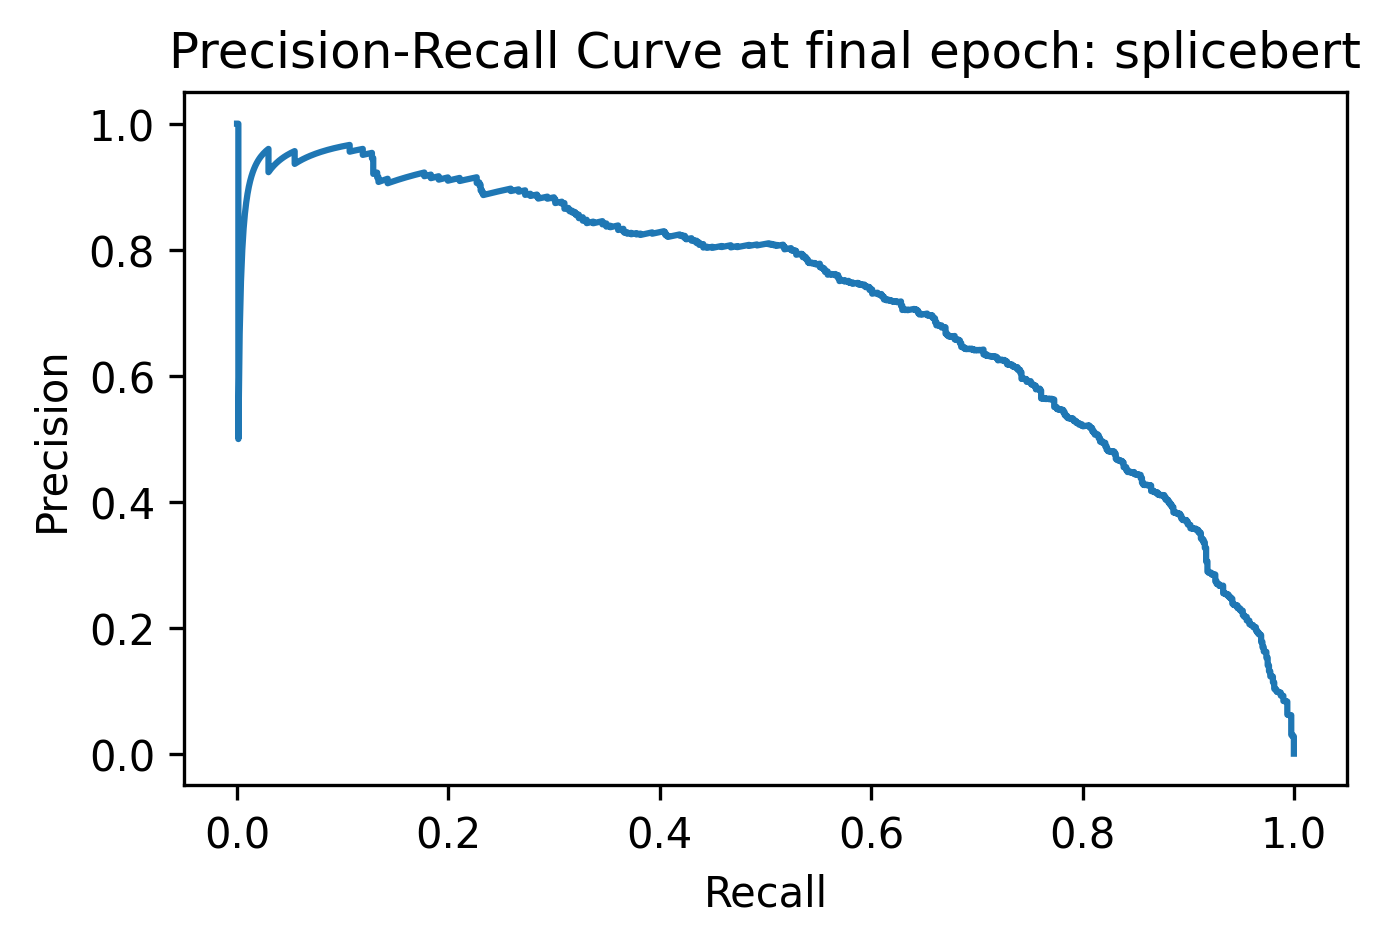

In [12]:
metrics = lambda x: compute_metrics(x, "test_metrics")
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics,
    # preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


In [13]:
trained_model = AutoModelForTokenClassification.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777") #make sure you are loading the right checkpoint
tokenizer = AutoTokenizer.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777")
data_collator = DataCollatorForTokenClassification(tokenizer)

OSError: multimolecule-utrlm-te_el-finetuned-secondary-structure/checkpoint-777 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
metric = lambda x: compute_metrics_test(x, "test_metrics", 0.001895)

testing_args = TrainingArguments(
    output_dir='/results',
    per_device_eval_batch_size=batch_size,
    do_eval=True,
    no_cuda=False,
)

tester = Trainer(
    model=trained_model,
    args=testing_args,
    eval_dataset=test_dataset,
    compute_metrics=metric,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

metrics = tester.evaluate()

print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")